In [1]:
from zumi.zumi import Zumi
from zumi.util.screen import Screen
import matplotlib.pyplot as plt
import numpy as np
import time

zumi = Zumi()

 Starting Zumi 
Pi Zero I2C is available
Verified Pi Zero is the same
Gyroscope previously calibrated
Zumi board detected
Compass detected
OLED Screen detected
Gyroscope & Accelerometer detected


1.1206896551724137  volts
 Starting Zumi 
Pi Zero I2C is available
Verified Pi Zero is the same
Gyroscope previously calibrated
Zumi board detected
Compass detected
OLED Screen detected
Gyroscope & Accelerometer detected
1.1206896551724137  volts
Creating new offset file...
.
.
traveled  20.0  cm  7.874015748031496  inches 
1.1583993434906006  time passed
samples per second
33.66714615227719
pred speed cm/s  16.002104557298296
slope int  1.2490556939570538


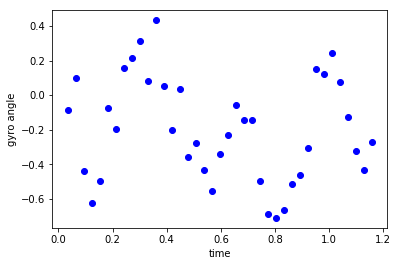

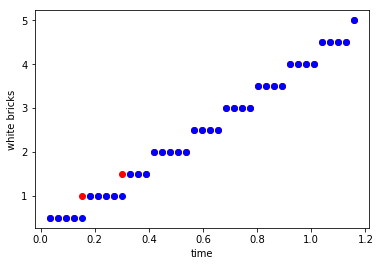

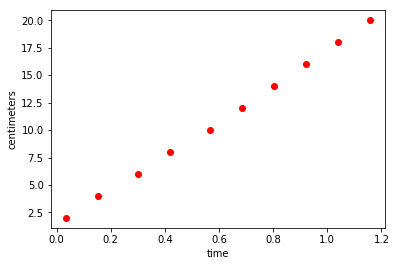

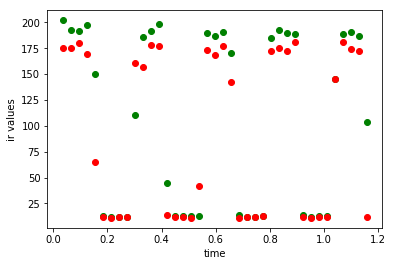

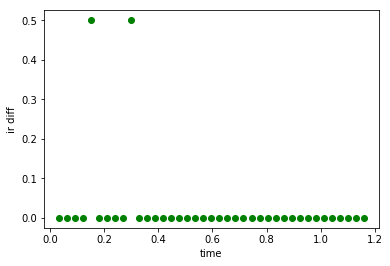

In [2]:
#the amount of bricks you wish to cross over
number_of_bricks = 5
motor_speed = 40
ir_threshold = 140
time_out = 3

print(zumi.get_battery_voltage()," volts")

# each white brick is 2cmx5cm 
# we are traveling toward the 
# brick from the 2cm length
# from end of one white brick
# to the end of another white brick
# is roughly 4 cm

cm_per_brick = 4
samples_taken = 0

zumi = Zumi()
zumi.MIN_I2C_DELAY = 0.01
print(zumi.get_battery_voltage()," volts")
zumi.reset_gyro()
zumi.mpu.calibrate_MPU(100)


#create list for the readings to be graphed
time_list = []
left_list = []
right_list = []

y = []
x = []

bin_left = []
bin_right = []

r_ir_list = []
l_ir_list = []
diff_lr= []
accx_list = []
accy_list = []
accz_list = []
ang_z_list = []

#create variables for calculating derivative
BLI_past = 0
BRI_past = 0
DBLI = 0
DBRI = 0
LBRICKS = 0
RBRICKS = 0

time_passed = 0
time_first_brick = 0
heading = 0
offset = 0

init_time = time.time()  
       
while(True):
    #zumi.go_straight(motor_speed,heading,accuracy=0.0)
    zumi.drive_at_angle(127, motor_speed, heading-1, 12, 0.1, 0, 0)
       
    ir_readings = zumi.get_all_IR_data()
    bottom_right_ir = ir_readings[1]
    bottom_left_ir = ir_readings[3]
    time_passed = time.time()-init_time
    
    if bottom_right_ir > ir_threshold:
        BRI = 1  
    else:
        BRI = 0
    if bottom_left_ir > ir_threshold:
        BLI = 1   
    else:
        BLI = 0
        
    DBRI = BLI - BLI_past
    DBLI = BRI - BRI_past
      
    if DBLI == -1:#falling edge or end of brick
        LBRICKS = LBRICKS + 0.5
        y.append(LBRICKS*cm_per_brick)
        x.append(time_passed)

    if DBRI == -1:#falling edge or end of brick
        RBRICKS = RBRICKS + 0.5
    
    
    if DBLI == 1:#rising edge start of brick
        LBRICKS = LBRICKS + 0.5
        y.append(LBRICKS*cm_per_brick)
        x.append(time_passed)
    if DBRI == 1 :#rising edge or start of brick
        RBRICKS = RBRICKS + 0.5

    #update past Binary Left IR (BLI)
    BLI_past = BLI
    #update past Binary Right IR (BRI)
    BRI_past = BRI
    

    
    if DBLI == -1 and LBRICKS ==1:
        time_first_brick = time_passed
        
    #DIFF_LR = (LBRICKS-RBRICKS)
    DIFF_LR = (LBRICKS-RBRICKS)
    
    #add data to lists
    time_list.append(time_passed)
    right_list.append(RBRICKS)
    left_list.append(LBRICKS)
    r_ir_list.append(bottom_right_ir)
    l_ir_list.append(bottom_left_ir)
    diff_lr.append(DIFF_LR)
    ang_z_list.append(zumi.angle_list[2])
    
    #program should end if timeout or number of bricks
    if time_passed > time_out:
        break
    if LBRICKS == number_of_bricks:
        break
    if RBRICKS == number_of_bricks:
        break
    
zumi.hard_brake()

print("traveled ",LBRICKS*cm_per_brick, " cm ",LBRICKS*cm_per_brick/2.54, " inches ")
print(time_passed," time passed")
print("samples per second")
print(len(time_list)/time_passed)

#calculate the predicted slope and slope intercept
#speed_cm_second, slope_intercept = np.polyfit(x, y, 1)

#DONT READ THE FIRST Reading as it skews the results.
speed_cm_second, slope_intercept = np.polyfit(x[1:], y[1:], 1)
print("pred speed cm/s ", speed_cm_second)
print("slope int ",slope_intercept)

plt.plot(time_list,ang_z_list,'bo')
plt.ylabel('gyro angle')
plt.xlabel('time')
plt.show()

plt.plot(time_list,left_list,'ro',time_list,right_list,'bo')
plt.ylabel('white bricks')
plt.xlabel('time')
plt.show()

plt.plot(x,y,'ro')
plt.ylabel('centimeters')
plt.xlabel('time')
plt.show()

plt.plot(time_list,l_ir_list,'go',time_list,r_ir_list,'ro')
plt.ylabel('ir values')
plt.xlabel('time')
plt.show()

plt.plot(time_list,diff_lr,'go')
plt.ylabel('ir diff')
plt.xlabel('time')
plt.show()


In [20]:
#file = open("speed_prediction.txt", "w+")
file = open("speed_prediction.txt", "a")

file.write(str(motor_speed)+ "\n" + str(speed_cm_second) + "\n" + str(slope_intercept)+"\n")
print("speed cm/second " + str(speed_cm_second) + ", slope int " + str(slope_intercept)+"\n")
file.close()
print("saved values to text file")
!cat speed_prediction.txt

speed cm/second 16.212976941143353, slope int 0.1794863411855374

saved values to text file
40
16.0376197463694
-0.11279578088151292
40
16.464449599684443
-0.01682758047545873
40
16.464449599684443
-0.01682758047545873
80
20.41148103408144
-0.37276484673974314
80
19.984848396493415
-0.4864749447579574
30
14.203360900187041
0.7575125537926971
40
16.535497925216916
-0.07822470679415498
40
16.66666899390032
0.09875436893528665
40
16.212976941143353
0.1794863411855374


15.972761332151784
0.6912240174778662
16.66666899390032
0.09875436893528665


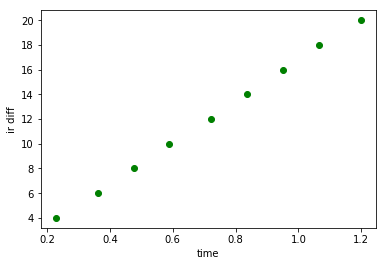

In [16]:
#calculate the predicted slope and slope intercept
speed_cm_second, slope_intercept = np.polyfit(x, y, 1)
print(speed_cm_second)
print(slope_intercept)

speed_cm_second, slope_intercept = np.polyfit(x[1:], y[1:], 1)
print(speed_cm_second)
print(slope_intercept)

plt.plot(x[1:],y[1:],'go')
plt.ylabel('ir diff')
plt.xlabel('time')
plt.show()